In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import newton, curve_fit, fsolve
from scipy.special import gamma, spherical_jn, spherical_yn
from scipy.interpolate import interp1d
from tqdm import tqdm

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4


gr = 4/3
h = 3
plt.style.use('science')

def mom(e):
    return np.sqrt(m*abs(e))


# Solves the radial (u) Schrödinger equation and returns arrays of r and u.
def solve_se(energy, V, rmin=1e-6, rmax=100.0, numpts=10000):
    rvalues = np.linspace(rmin, rmax, numpts)
    uinit = np.array([0., 1.]) # initial u and u' conditions
    g = lambda u, r: np.array([u[1], (2 * MU) * (V(r) - energy) * u[0]])
    w = odeint(g, uinit, rvalues, mxstep=20000)
    return (rvalues, w[:, 0])


# Solves the Schrödinger equation for a given energy
# and returns the difference: u(r_max) - exp(-k*r_max).
def solve_se_eval_rmax(energy, V, rmin = 1e-6, rmax = 100.0, numpts = 10000):
    r, u = solve_se(energy, V = V, rmin = rmin, rmax = rmax, numpts = numpts)
    k = np.sqrt(2*MU*np.abs(energy))
    return u[-1]
#     return (u[-1] - np.exp(-k * r[-1]) if u[-1] > 0 else u[-1] + np.exp(-k * r[-1]))


def bound_state(guess, V, rmin = 1e-6, rmax = 100.0, numpts = 10000, tol = 1e-9):
    return newton(lambda e: solve_se_eval_rmax(e, V, rmin, rmax, numpts), x0 = guess, maxiter = 10000,
                                               tol = tol)

def scattering_length(V, rmin = 1e-6, rmax = 100.0, numpts = 10000):
    r, u = solve_se(0, V, rmin, rmax, numpts)
    m = (u[-5] - 8 * u[-4] + 8 * u[-2] - u[-1]) / (12 * (r[-1] - r[-2]))
    b = u[-1] - m * r[-1]
    return -b / m


def index_for_value(value, array):
    for (i, ai) in enumerate(array):
        if ai >= value:
            return i
    return -1


def phaseShift(energy, V, r0, rmin = 1e-6, rmax = 100.0, numpts = 10000):
    r, u = solve_se(energy, V = V, rmin = rmin, rmax = rmax, numpts = numpts)
    k = mom(energy)
    i = index_for_value(r0, r)
    i += int(numpts * 0.75)
    # rp = r[i]
    dr = r[1] - r[0]
    R = u / r
    fp = (-R[i + 2] + 8 * R[i + 1] - 8 * R[i - 1] + R[i - 2]) / (12 * dr)
    beta = r[i] * (fp / R[i])
    x = k * r[i]
    j = spherical_jn(0, x)
    jp = spherical_jn(0, x, derivative=True)
    y = spherical_yn(0, x)
    yp = spherical_yn(0, x, derivative=True)
    tandelta = (x * jp - beta * j) / (x * yp - beta * y)
    delta = np.arctan(tandelta)
    return delta

In [2]:
rgflow = np.loadtxt('rgflow_local_lo_a0_fix.txt')
spectra = np.loadtxt('spectra_local_lo_a0_fix.txt')

In [3]:
n = rgflow.shape[0]

In [9]:
spectra_coord = []
for i in tqdm(range(n)):
    Ri, gi = rgflow[i]
    guesses = spectra[i, 1:]
    spec = [bound_state(guess, lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri), rmax=50)
            for guess in guesses]
    spectra_coord.append(spec)

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 46/50 [00:12<00:02,  1.73it/s]/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_72453/1419089773.py:26: RuntimeWarning: overflow encountered in double_scalars
  g = lambda u, r: np.array([u[1], (2 * MU) * (V(r) - energy) * u[0]])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 46/50 [00:12<00:01,  3.76it/s]

 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4732973302670D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.4732696716124D+02   r2 =  0.4732696716124D+02
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4733473352665D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.4732696716124D+02   r2 =  0.4732696716124D+02
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.4733473352665D+02
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4736973702630D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.4736896007694D+02   r2 =  0.4736896007694D+02
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4737473752625D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.4736896007694D+02   r2 =  0.4

RuntimeError: Tolerance of -0.000126971164191525 reached. Failed to converge after 1 iterations, value is -0.26983861307965257.

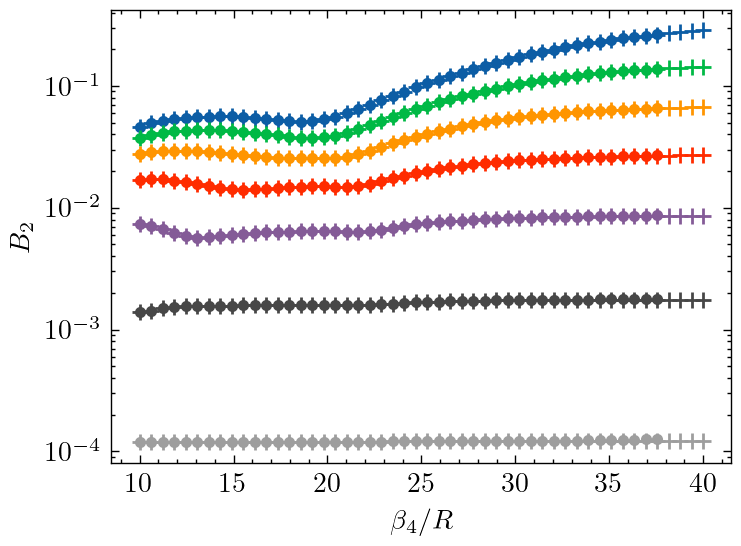

In [10]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for (i, spec) in enumerate(spectra_coord):
    for s in spec:
        ax.scatter(BETA4/rgflow[i, 0], np.abs(s), marker='.')

for (i, spec) in enumerate(spectra[:, 1:]):
    for s in spec:
        ax.scatter(BETA4/rgflow[i, 0], np.abs(s), marker='+')

ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$B_2$')
ax.set_yscale('log');

In [38]:
scattering_lengths = []
for i in tqdm(range(n)):
    Ri, gi = rgflow[i]
    scattering_lengths.append(scattering_length(
        lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri), rmax=200, numpts=20000)
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.35it/s]


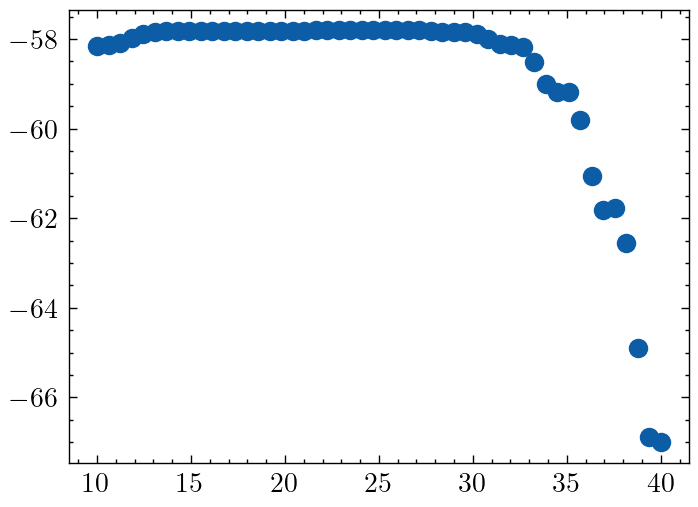

In [39]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.scatter(BETA4/rgflow[:, 0], scattering_lengths);

In [41]:
wavefunctions = []
for i in tqdm(range(n)):
    Ri, gi = rgflow[i]
    r, u = solve_se(0, lambda r: potential(r, Ri) + gi*local_LO_counterterm(r, Ri), rmax=200, numpts=20000)
    wavefunctions.append(u)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 193.26it/s]


(-25.0, 25.0)

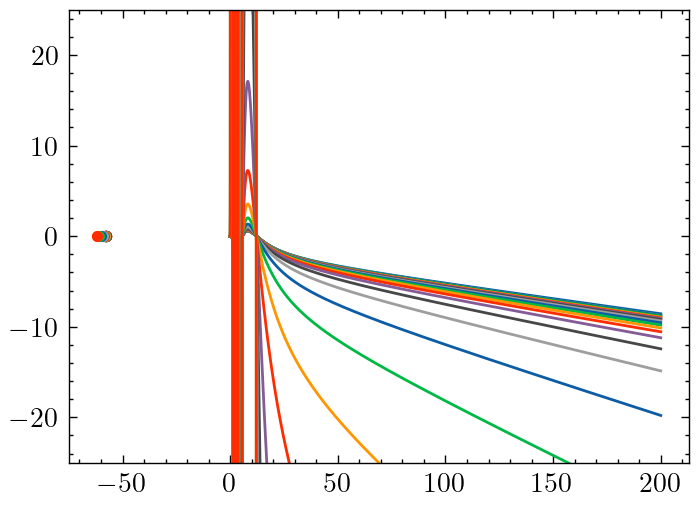

In [42]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for wf in wavefunctions[:-4]:
    ax.plot(r, wf)

for a0 in scattering_lengths[:-4]:
    ax.scatter(a0, 0, marker='.')

ax.set_ylim([-25, 25])